In [17]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [18]:

classification_data, classification_labels = make_classification(n_features=2, n_informative=2, n_classes=2,
                                                                 n_redundant=0, n_clusters_per_class=1, random_state=5)

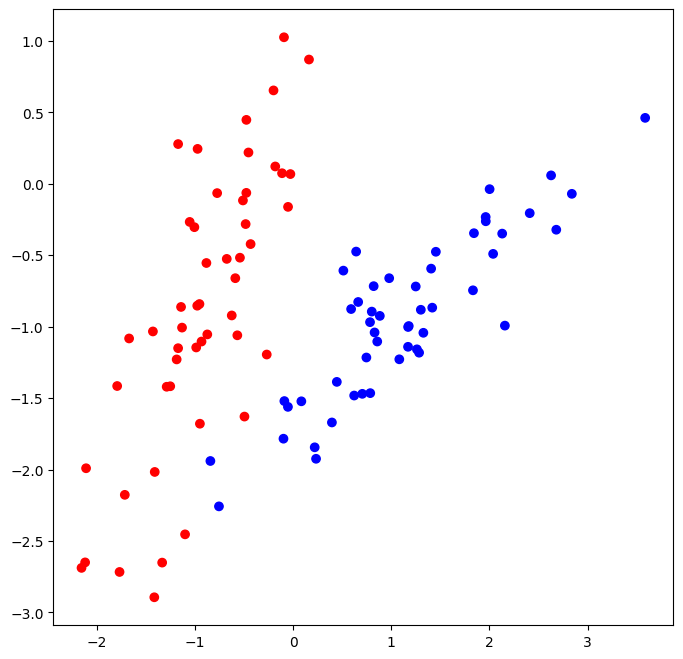

In [19]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8, 8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)),
            c=classification_labels, cmap=colors)

In [20]:
class Node:
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index
        self.t = t
        self.true_branch = true_branch
        self.false_branch = false_branch


class Leaf:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()

    def predict(self):
        classes = {}
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1

        prediction = max(classes, key=classes.get)
        return prediction

In [21]:
def gini(labels):
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1

    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2

    return impurity


def gain(left_labels, right_labels, root_gini):
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [22]:
def split(data, labels, column_index, t):
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)

    true_data = data[left]
    false_data = data[right]

    true_labels = labels[left]
    false_labels = labels[right]

    return true_data, false_data, true_labels, false_labels


def find_best_split(data, labels):
    min_samples_leaf = 3

    root_gini = gini(labels)

    best_gain = 0
    best_t = best_index = None

    n_features = data.shape[1]

    for i in range(n_features):
        t_values = np.unique(data[:, i])

        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, i, t)
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue

            current_gain = gain(true_labels, false_labels, root_gini)

            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, i

    return best_gain, best_t, best_index

In [40]:
def build_tree(data, labels, max_leaves=None, max_signs=None, max_depth=None):
    gain, t, index = find_best_split(data, labels)
    
    # Stop criterion: number of leaves
    if max_leaves is not None and max_leaves <= 0:
        return Leaf(data, labels)

    # Stop criterion: number of signs used
    if max_signs is not None and max_signs <= 0:
        return Leaf(data, labels)

    # Stop criterion: tree depth
    if max_depth is not None and max_depth <= 0:
        return Leaf(data, labels)
    
    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Decrement the stop criteria for the recursive calls
    new_max_leaves = max_leaves - 1 if max_leaves is not None else None
    new_max_signs = max_signs - 1 if max_signs is not None else None
    new_max_depth = max_depth - 1 if max_depth is not None else None
    
    true_branch = build_tree(true_data, true_labels, new_max_leaves, new_max_signs, new_max_depth)
    false_branch = build_tree(false_data, false_labels, new_max_leaves, new_max_signs, new_max_depth)

    return Node(index, t, true_branch, false_branch)


def classify_objects(obj, node):
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_objects(obj, node.true_branch)
    else:
        return classify_objects(obj, node.false_branch)

In [41]:
def predict(data, tree):
    classes = []
    for obj in data:
        prediction = classify_objects(obj, tree)
        classes.append(prediction)
    return classes

In [42]:
train_data, test_data, train_labels, test_labels = train_test_split(classification_data, classification_labels,test_size=0.3, random_state=1)

In [43]:
my_tree = build_tree(train_data, train_labels)

In [44]:
def print_tree(node, spacing=""):
    if isinstance(node, Leaf):
        print(spacing + "Predict", node.prediction)
        return
    
    print(spacing + str(node.index) + "<=" + str(node.t))
    print(spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")
    
    print(spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

In [45]:
print_tree(my_tree)

0<=0.16261402870113306
--> True:
  1<=-1.5208896621663803
  --> True:
    0<=-0.9478301462477035
    --> True:
      Predict 0
    --> False:
      0<=-0.09712237000978252
      --> True:
        Predict 1
      --> False:
        Predict 1
  --> False:
    Predict 0
--> False:
  Predict 1


In [46]:
train_answers = predict(train_data, my_tree)
answers = predict(test_data, my_tree) 

In [47]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [48]:
train_accuracy = accuracy_metric(train_labels, train_answers)
test_accuracy = accuracy_metric(test_labels, answers)
print(train_accuracy)
print(test_accuracy)

98.57142857142858
100.0


In [49]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

def visualize(train_data, test_data):
    plt.figure(figsize = (16, 7))
    plt.subplot(1,2,1)
    
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f"Train accuracy = {train_accuracy:.2f}")
    
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f"Test accuracy = {test_accuracy:.2f}")

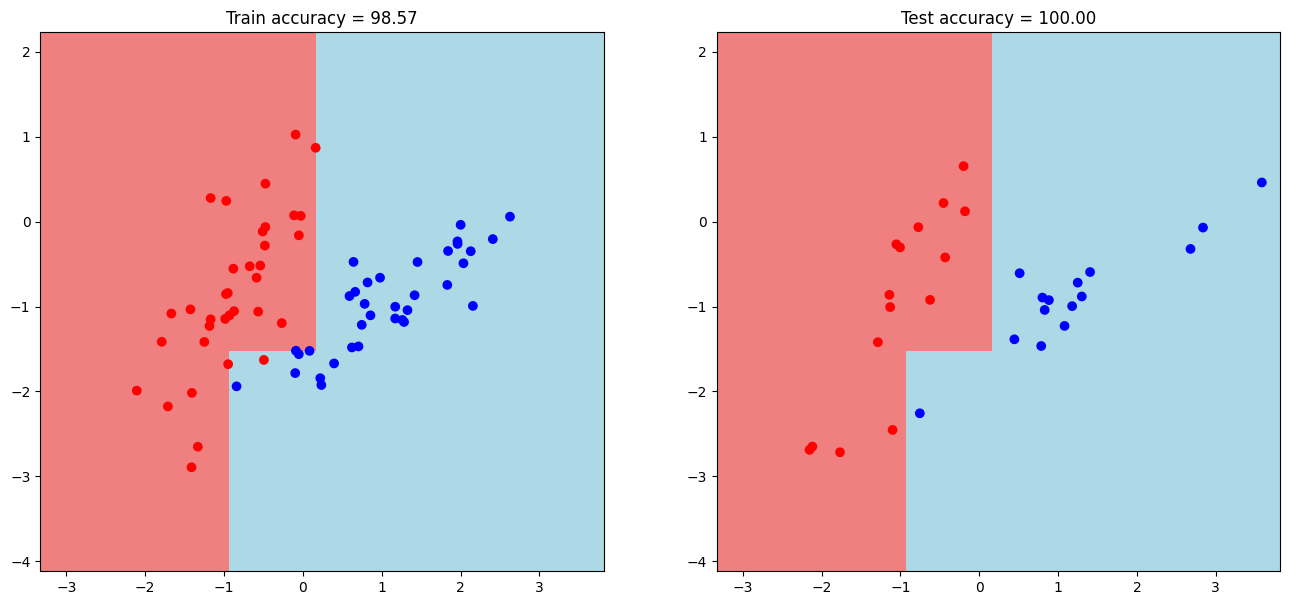

In [50]:
visualize(train_data, test_data)